In [17]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline
from scipy.signal import find_peaks
from scipy.integrate import simpson
from scipy.ndimage import minimum_filter
from scipy.signal import savgol_filter
 
# ---------------------------
# Funktion: Datei einlesen, Baseline korrigieren & Peaks finden
# ---------------------------
def process_file(filepath,
                 lam=1e6,
                 p=0.001,
                 peak_distance=5,           # deutlich kleiner als vorher
                 peak_window=3,
                 baseline_start=90,
                 peak_mask_prominence_factor=0.02,   # Prominenz-Faktor für die Maskierung beim Fit
                 fallback_minfilter_fraction=0.02,   # Fallback: Fenstergröße als Bruchteil des Fit-Bereichs
                 final_prominence_factor=0.01):      # Prominenz für die finale Peak-Find
    """
    Lädt Datei, sortiert nach m/z, maskiert Peaks im Fit-Bereich (mit Prominenz),
    fitet Baseline ab baseline_start (ALS). Falls keine Peaks gefunden werden,
    probiert ein alternatives Baseline-Verfahren (minimum_filter + savgol).
    Rückgabe: mz, intensity, baseline, corrected, peaks_indices, peak_data
    """

    with open(filepath, encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    # Header suchen
    try:
        start_index = next(
            i for i, line in enumerate(lines) if line.strip().startswith("Mass / Counts")
        ) + 1
    except StopIteration:
        print(f"⚠️ Kein Header 'Mass / Counts' in Datei: {filepath}")
        return None, None, None, None, [], []

    data = [line.strip().split("\t") for line in lines[start_index:] if line.strip()]
    mz = np.array([float(row[0]) for row in data])
    intensity = np.array([float(row[1]) for row in data])

    if len(mz) == 0 or len(intensity) == 0:
        print(f"⚠️ Leere Daten in Datei: {filepath}")
        return None, None, None, None, [], []

    # sicherstellen, dass mz aufsteigend ist
    order = np.argsort(mz)
    mz = mz[order]
    intensity = intensity[order]

    # Startindex für Baseline-Fit (exakt, mit searchsorted)
    start_idx = np.searchsorted(mz, baseline_start)
    if start_idx >= len(mz):
        print(f"⚠️ Kein m/z >= {baseline_start} in Datei: {os.path.basename(filepath)}")
        baseline = np.zeros_like(intensity)
        corrected = intensity - baseline
        peaks_final = np.array([], dtype=int)
        peak_data = []
        return mz, intensity, baseline, corrected, peaks_final, peak_data

    # Fit-Bereich
    intensity_fit = intensity[start_idx:]
    n_fit = len(intensity_fit)

    # --- 1) Peaks im Fit-Bereich maskieren (mit Prominenz) ---
    # Prominenz-Schwelle relativ zum lokalen Maximum
    prom_thresh = peak_mask_prominence_factor * max(np.max(intensity_fit), 1.0)
    # find_peaks mit Prominenz (robuster gegenüber baselines)
    peaks_in_fit, props = find_peaks(intensity_fit, prominence=prom_thresh, distance=max(1, int(peak_distance/2)))
    peak_mask = np.zeros_like(intensity_fit, dtype=bool)
    mask_width = max(1, int(peak_window))  # Breite um Peaks herum maskieren
    for pi in peaks_in_fit:
        lo = max(0, pi - mask_width)
        hi = min(n_fit, pi + mask_width + 1)
        peak_mask[lo:hi] = True

    # Interpolieren über maskierte Stellen (so beeinflussen Peaks den Fit nicht)
    x_fit = np.arange(n_fit)
    good = ~peak_mask
    intensity_fit_masked = intensity_fit.copy()
    if good.sum() >= 2:
        intensity_fit_masked[~good] = np.interp(x_fit[~good], x_fit[good], intensity_fit[good])
    else:
        intensity_fit_masked = intensity_fit.copy()

    # --- 2) ALS-Baseline auf maskierten Fit-Daten ---
    baseline_fit = Baseline(intensity_fit_masked).asls(lam=lam, p=p)[0]

    # Baseline für Gesamtbereich vorbereiten
    baseline = np.zeros_like(intensity)
    baseline[start_idx:] = baseline_fit
    # optional: vor start_idx konstant fortführen, um Kante zu vermeiden:
    # baseline[:start_idx] = baseline_fit[0]

    corrected = intensity - baseline

    
    # -------- Peaks auf korrigierten Daten --------
    # nur m/z >= 15 verwenden
    mask = mz >= 15
    mz_peaks = mz[mask]
    corrected_peaks = corrected[mask]

    # Rauschlevel aus Bereich < 15 bestimmen
    noise_mask = mz < 15
    noise_level = np.std(corrected[noise_mask]) if np.any(noise_mask) else np.std(corrected)

    # dynamischer Schwellenwert
    threshold = noise_level * 10   # Faktor anpassen (z.B. 3–10)

    peaks, _ = find_peaks(corrected_peaks, height=threshold, distance=peak_distance)

    # Integration pro Peak
    peak_data = []
    for peak in peaks:
        start = max(peak - peak_window, 0)
        end = min(peak + peak_window + 1, len(mz_peaks))
        area = simpson(corrected_peaks[start:end], mz_peaks[start:end])
        peak_data.append({'m/z': mz_peaks[peak], 'area': area})
    # Integrationen
    peak_data = []
    for peak in peaks:
        start = max(peak - peak_window, 0)
        end = min(peak + peak_window + 1, len(mz))
        area = simpson(corrected[start:end], mz[start:end])
        peak_data.append({'m/z': mz[peak], 'area': area})

    # --- Fallback: Falls keine Peaks gefunden wurden, probiere alternative Baseline ---
    fallback_used = False
    if len(peaks) == 0:
        fallback_used = True
        # Minimum-Filter Fenster als Bruchteil der Fit-Länge
        win = max(3, int(n_fit * fallback_minfilter_fraction))
        if win % 2 == 0:
            win += 1
        # Minimum-Filter + Savgol glätten
        try:
            minf = minimum_filter(intensity_fit, size=win)
            sg_win = min(101, win if win % 2 == 1 else win+1)
            if sg_win < 3:
                sg_win = 3
            baseline_fit_alt = savgol_filter(minf, window_length=sg_win, polyorder=2)
        except Exception:
            # Falls etwas schief geht, fallback auf einfache moving minimum via numpy
            baseline_fit_alt = minimum_filter(intensity_fit, size=win)

        baseline_alt = np.zeros_like(intensity)
        baseline_alt[start_idx:] = baseline_fit_alt
        corrected_alt = intensity - baseline_alt

        # neue Peak-Find mit lockereren Parametern
        max_corr_alt = np.max(corrected_alt)
        std_corr_alt = np.std(corrected_alt)
        if max_corr_alt > 0:
            prom_alt = max(0.005 * max_corr_alt, std_corr_alt)
            height_alt = max(1e-6 * max_corr_alt, np.mean(corrected_alt) + 1.0 * std_corr_alt)
        else:
            prom_alt = max(1.0, std_corr_alt)
            height_alt = np.mean(corrected_alt) + 1.0 * std_corr_alt

        peaks_alt, props_alt = find_peaks(corrected_alt, height=height_alt, prominence=prom_alt, distance=max(1, int(peak_distance/2)))

        if len(peaks_alt) > 0:
            # wechsle auf fallback-baseline
            baseline = baseline_alt
            corrected = corrected_alt
            peaks_final = peaks_alt
            peak_data = []
            for peak in peaks_final:
                start = max(peak - peak_window, 0)
                end = min(peak + peak_window + 1, len(mz))
                area = simpson(corrected[start:end], mz[start:end])
                peak_data.append({'m/z': mz[peak], 'area': area})

    # Debug-Ausgabe
    print(f"File: {os.path.basename(filepath)} | mz_range: {mz.min():.2f}-{mz.max():.2f} | "
          f"fit points: {n_fit} (first mz_fit={mz[start_idx]:.2f}) | "
          f"peaks_masked_in_fit: {len(peaks_in_fit)} | peaks_found_total: {len(peaks_final)}"
          + (f" | fallback_used" if fallback_used else ""))

    return mz, intensity, baseline, corrected, peaks, peak_data
# ---------------------------
# Hauptprogramm
# ---------------------------
folder = r"C:\Users\adako\Desktop\Wabenreaktor_Alacac3\Messdaten_Ilyas\8mm Wabe_Reproduzierung\2025-09-10\TR200"
files = [f for f in os.listdir(folder) if f.endswith(".asc")]
print(f"{len(files)} .asc-Dateien gefunden.")
 
all_peaks = []
all_spectra = []
 
for file in files:
    filepath = os.path.join(folder, file)
    print(f"\n== Bearbeite Datei: {file} ==")
 
    mz, intensity, baseline, corrected, peaks, peak_data = process_file(filepath)
 
    if mz is None:
        continue
 
    meta = extract_metadata(file)
 
    # Spektrum speichern
    df_spec = pd.DataFrame({
        'm/z': mz,
        'intensity_raw': intensity,
        'baseline': baseline,
        'intensity_corrected': corrected
    })
    for key, value in meta.items():
        df_spec[key] = value
    df_spec['Datei'] = file
    all_spectra.append(df_spec)
 
    # Peaks speichern
    for peak in peak_data:
        peak.update(meta)
        peak['Datei'] = file
        all_peaks.append(peak)
 
    # Plot zur Kontrolle
    plt.figure(figsize=(9, 5))
    plt.plot(mz, intensity, color='gray', alpha=0.5, label="Raw")
    plt.plot(mz, baseline, 'r--', label="Baseline")
    plt.plot(mz, corrected, 'b', label="Corrected")
    if len (peaks)>0:
        plt.scatter(mz[peaks], corrected[peaks], color='k', marker='x', label="Peaks")
    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.title(f"Baseline-Korrektur: {file}")
    plt.legend()
    plt.ylim(0,3000)
    plt.tight_layout()
    plt.show()
 
# ---------------------------
# Ergebnisse speichern
# ---------------------------
if len(all_spectra) > 0:
    df_all_spec = pd.DataFrame(pd.concat(all_spectra, ignore_index=True))
    df_all_spec.to_csv("alle_spektren_mit_baseline.csv", index=False)
    print("✅ Spektren mit Baseline-Korrektur gespeichert in 'alle_spektren_mit_baseline.csv'")
 
if len(all_peaks) > 0:
    df_all_peaks = pd.DataFrame(all_peaks)
    df_all_peaks.to_csv("alle_peaks_korrigiert.csv", index=False)
    print("✅ Integrierte Peaks gespeichert in 'alle_peaks_korrigiert.csv'")



14 .asc-Dateien gefunden.

== Bearbeite Datei: 003-650sccm-tr200.asc ==
File: 003-650sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 (first mz_fit=90.00) | peaks_masked_in_fit: 13089 | peaks_found_total: 85 | fallback_used


NameError: name 'extract_metadata' is not defined

Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0
Baseline (min/max): nan nan
Intensity (min/max): 0.0 3933044.0


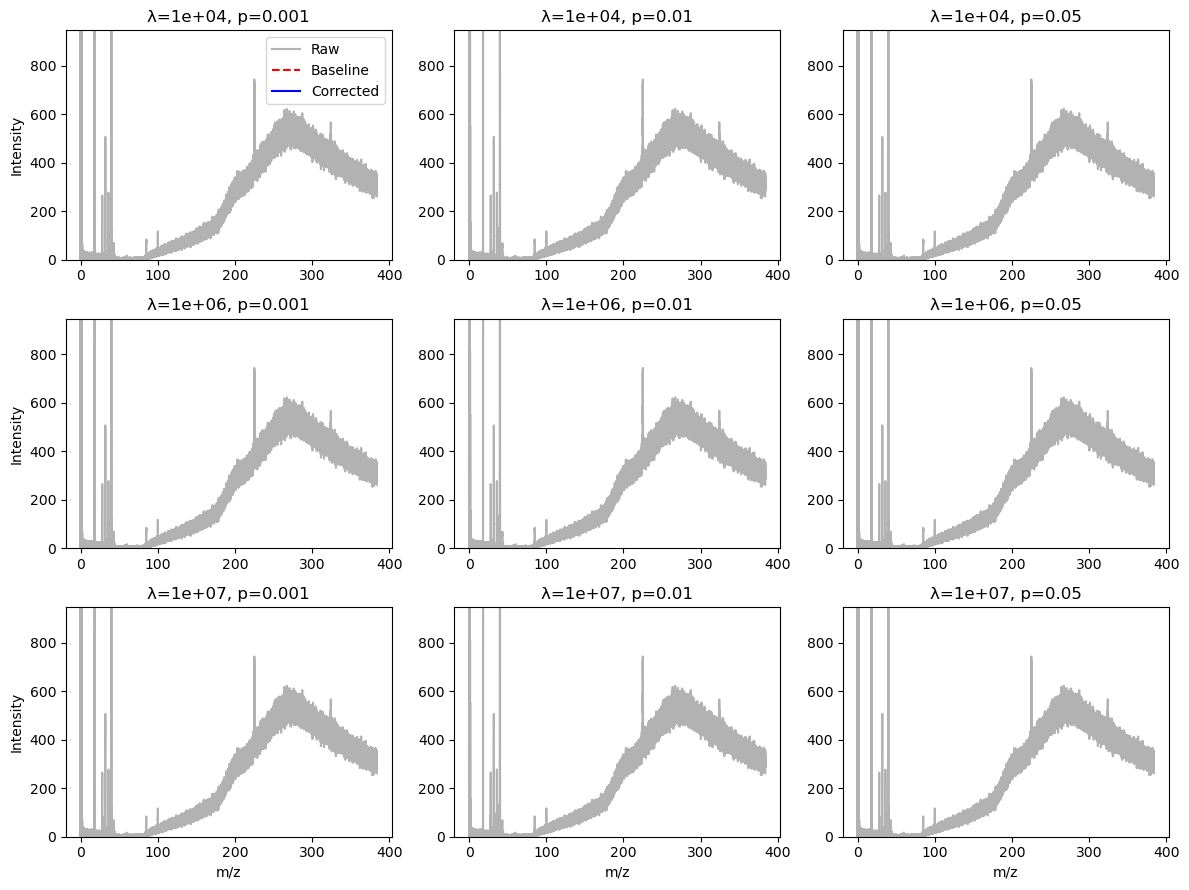

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline

# ---------------------------
# Funktion für Baseline-Test
# ---------------------------
def test_baseline(mz, intensity, lam_values=[1e4, 1e6, 1e7], p_values=[0.001, 0.01, 0.05]):
    nrows = len(lam_values)
    ncols = len(p_values)

    plt.figure(figsize=(4 * ncols, 3 * nrows))

    for i, lam in enumerate(lam_values):
        for j, p in enumerate(p_values):
            # Baseline berechnen
            baseline_fitter = Baseline(intensity)
            baseline = baseline_fitter.asls(lam=lam, p=p)[0]
            print("Baseline (min/max):", baseline.min(), baseline.max())
            print("Intensity (min/max):", intensity.min(), intensity.max())
            corrected = intensity - baseline

            # Plot in Subplot
            ax = plt.subplot(nrows, ncols, i * ncols + j + 1)
            ax.plot(mz, intensity, color="gray", alpha=0.6, label="Raw")
            ax.plot(mz, baseline, "r--", label="Baseline")
            ax.plot(mz, corrected, "b", label="Corrected")
            ax.set_title(f"λ={lam:.0e}, p={p}")
            ax.set_ylim(0, np.percentile(intensity, 99))  # skaliere Y-Achse automatisch
            if i == nrows - 1:
                ax.set_xlabel("m/z")
            if j == 0:
                ax.set_ylabel("Intensity")
            if i == 0 and j == 0:
                ax.legend()

    plt.tight_layout()
    plt.show()

# ---------------------------
# Beispiel: eine Datei laden
# ---------------------------
def load_file(filepath):
    with open(filepath, encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    # Header finden
    start_index = next(
        i for i, line in enumerate(lines) if line.strip().startswith("Mass / Counts")
    ) + 1
    data = [line.strip().split("\t") for line in lines[start_index:] if line.strip()]
    mz = np.array([float(row[0]) for row in data])
    intensity = np.array([float(row[1]) for row in data])
    return mz, intensity

# ---------------------------
# Hauptteil
# ---------------------------
file = r"C:\Users\adako\Desktop\Wabenreaktor_Alacac3\Messdaten_Ilyas\8mm Wabe_Reproduzierung\2025-09-10\TR200\003-650sccm-tr200.asc"

mz, intensity = load_file(file)
test_baseline(mz, intensity)

14 .asc-Dateien gefunden.

== Bearbeite Datei: 003-650sccm-tr200.asc ==
83398.08235978072
File: 003-650sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 13089 | peaks_found_total: 85 | fallback_used


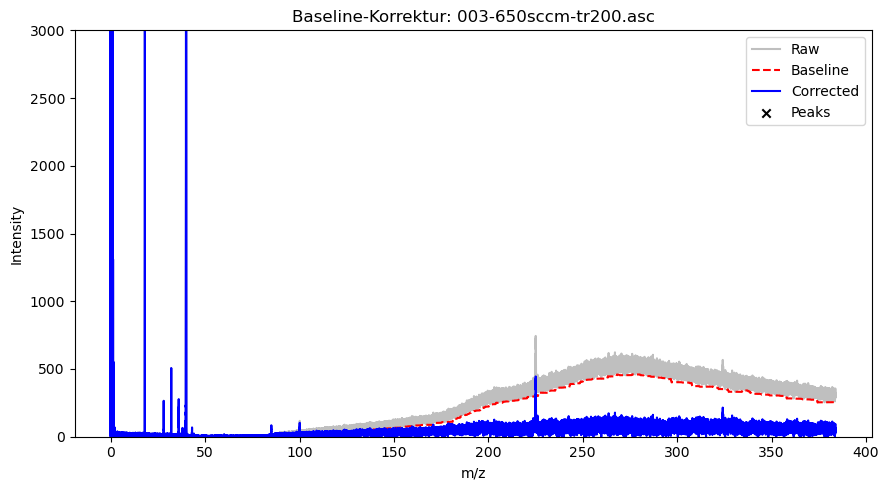


== Bearbeite Datei: 004-600sccm-tr200.asc ==
82752.77448662977
File: 004-600sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 12093 | peaks_found_total: 84 | fallback_used


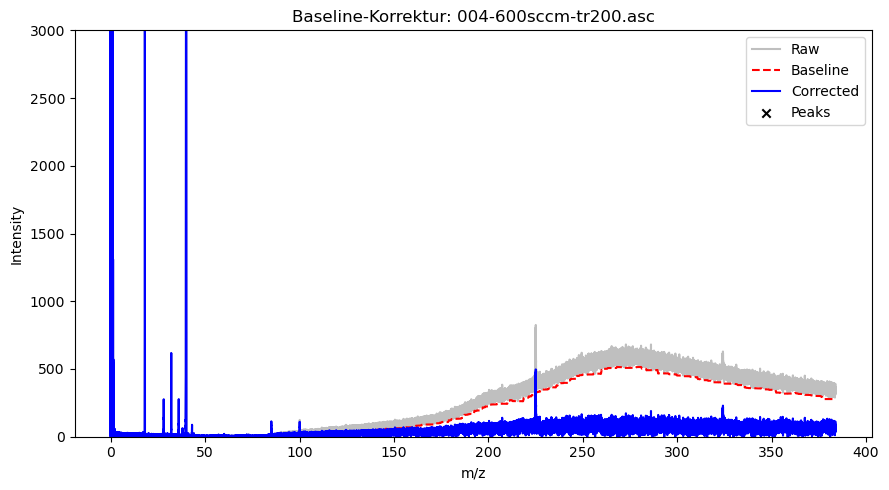


== Bearbeite Datei: 005-550sccm-tr200.asc ==
82860.50179220104
File: 005-550sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11889 | peaks_found_total: 84 | fallback_used


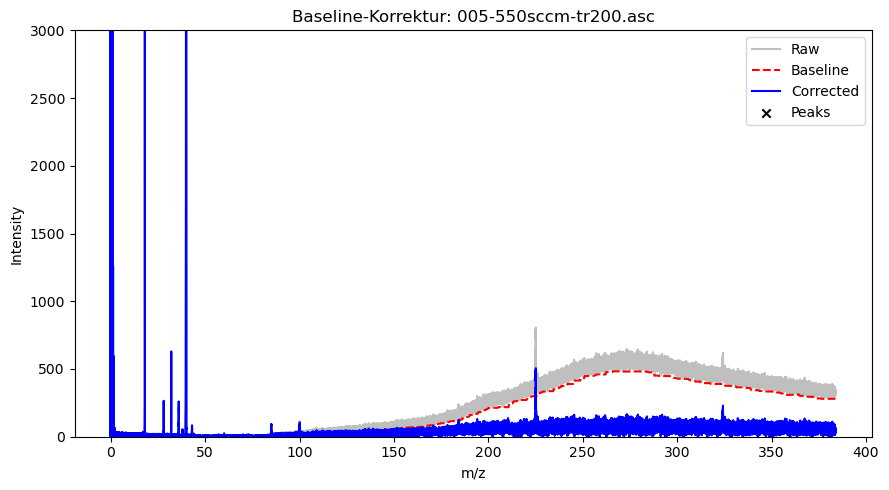


== Bearbeite Datei: 006-500sccm-tr200.asc ==
82361.11781424758
File: 006-500sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11642 | peaks_found_total: 82 | fallback_used


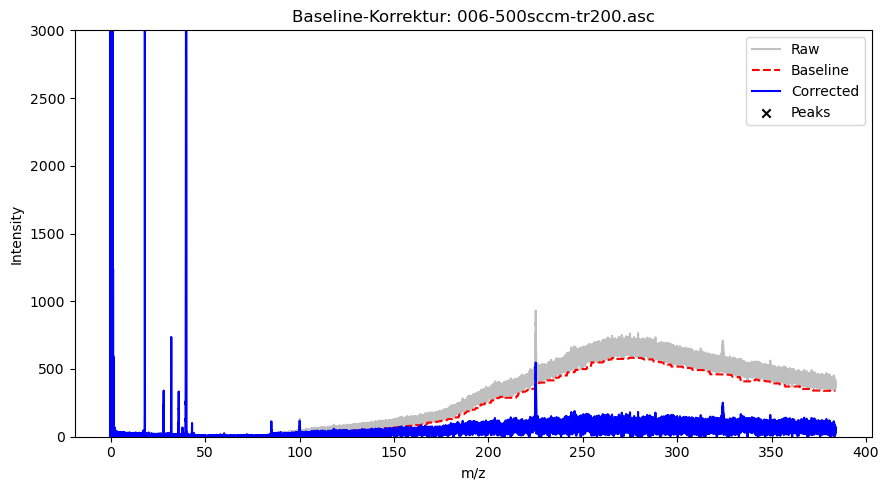


== Bearbeite Datei: 007-450sscm-tr200.asc ==
82392.20457068604
File: 007-450sscm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11030 | peaks_found_total: 83 | fallback_used


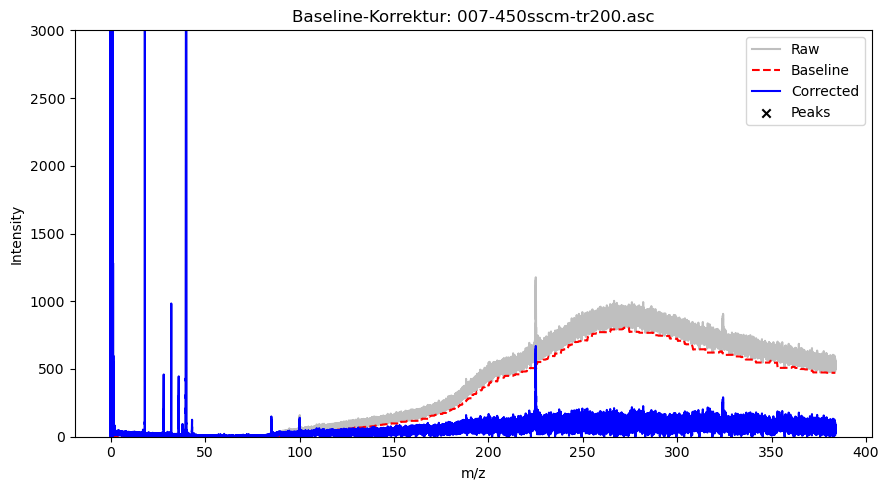


== Bearbeite Datei: 008-400sccm-tr200.asc ==
82664.3311926677
File: 008-400sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 10374 | peaks_found_total: 85 | fallback_used


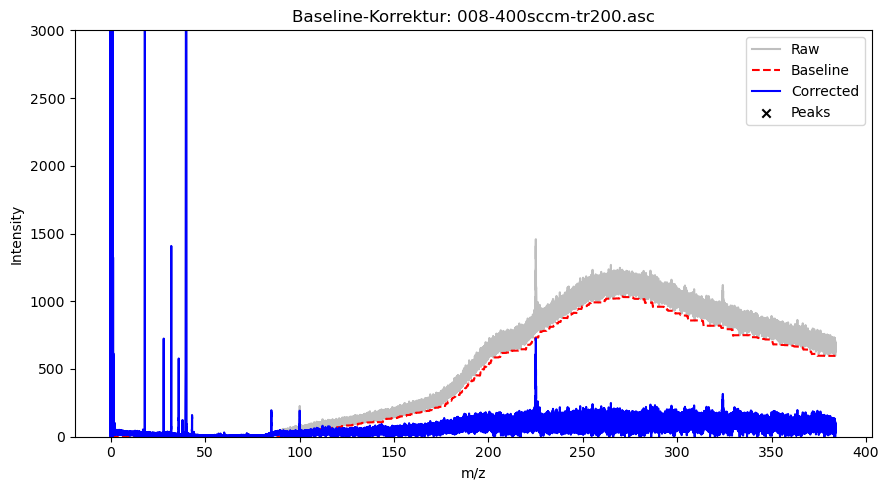


== Bearbeite Datei: 009-350sccm-tr200.asc ==
82910.45774387504
File: 009-350sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11004 | peaks_found_total: 84 | fallback_used


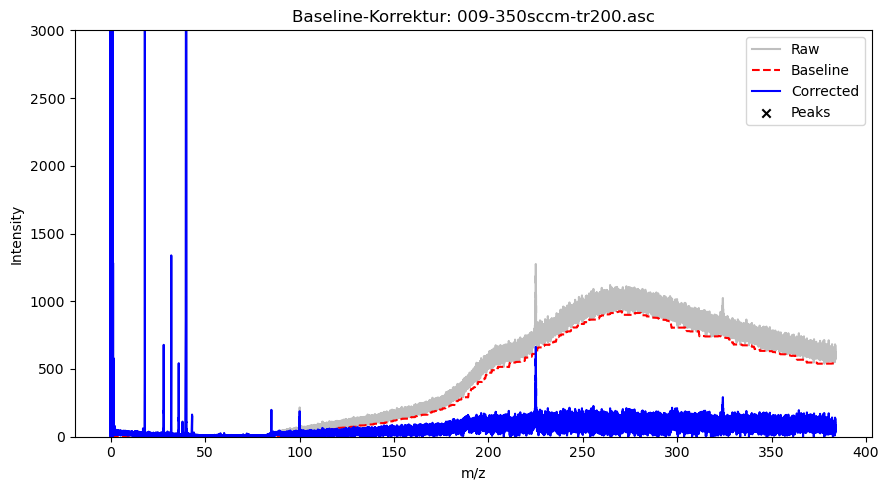


== Bearbeite Datei: 010-300sccm-tr200.asc ==
82879.55357067716
File: 010-300sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11212 | peaks_found_total: 84 | fallback_used


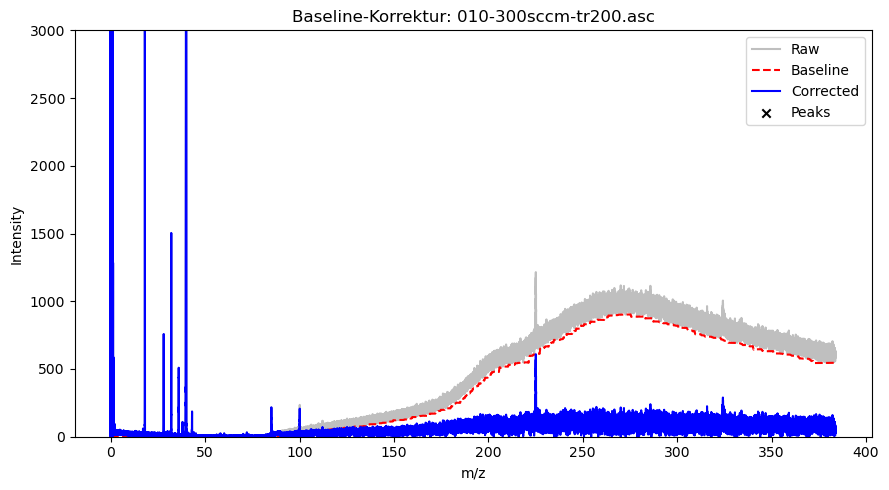


== Bearbeite Datei: 011-200sccm-tr200.asc ==
83345.6244878404
File: 011-200sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11385 | peaks_found_total: 84 | fallback_used


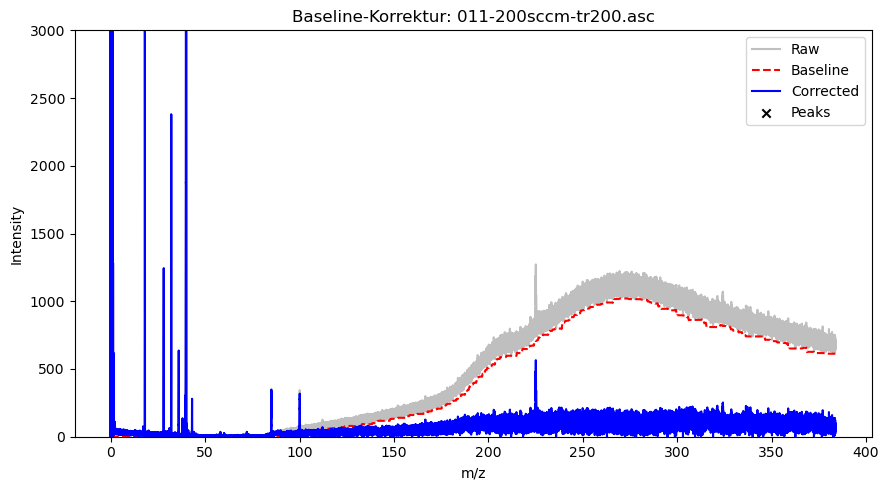


== Bearbeite Datei: 012-150sccm-tr200.asc ==
83640.69200585983
File: 012-150sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11322 | peaks_found_total: 84 | fallback_used


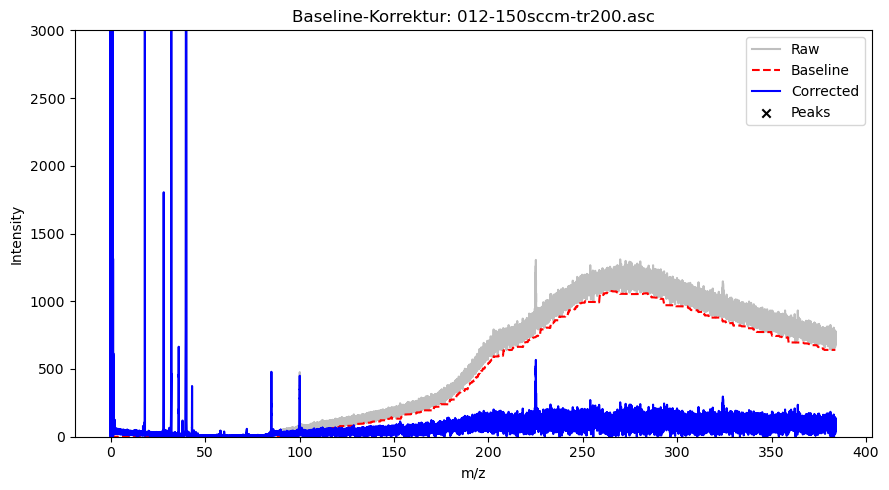


== Bearbeite Datei: 013-100sccm-tr200.asc ==
83643.08447966051
File: 013-100sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11198 | peaks_found_total: 84 | fallback_used


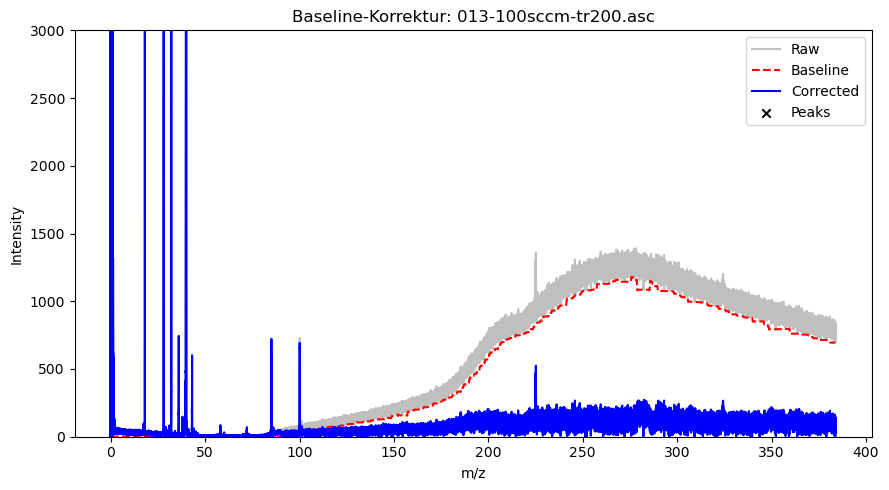


== Bearbeite Datei: 016-700sccm-tr200.asc ==
83780.30013099097
File: 016-700sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 10781 | peaks_found_total: 85 | fallback_used


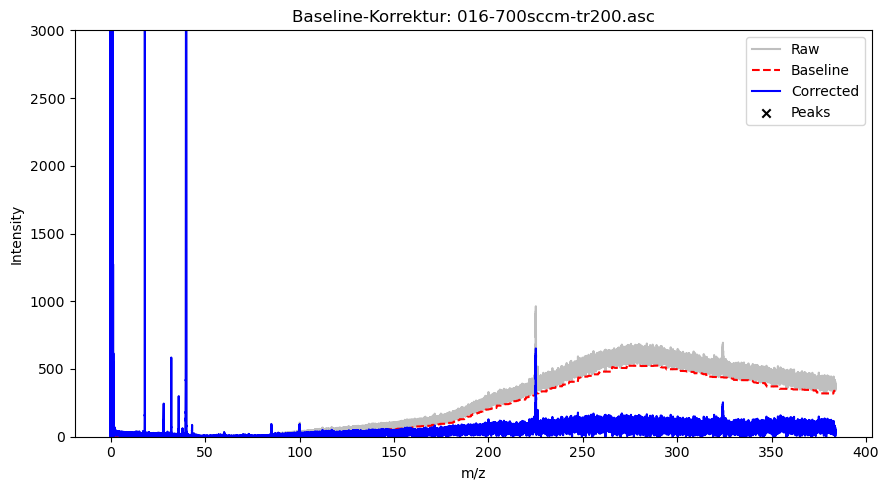


== Bearbeite Datei: 017-250sccm-tr200.asc ==
84088.25913602175
File: 017-250sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11047 | peaks_found_total: 85 | fallback_used


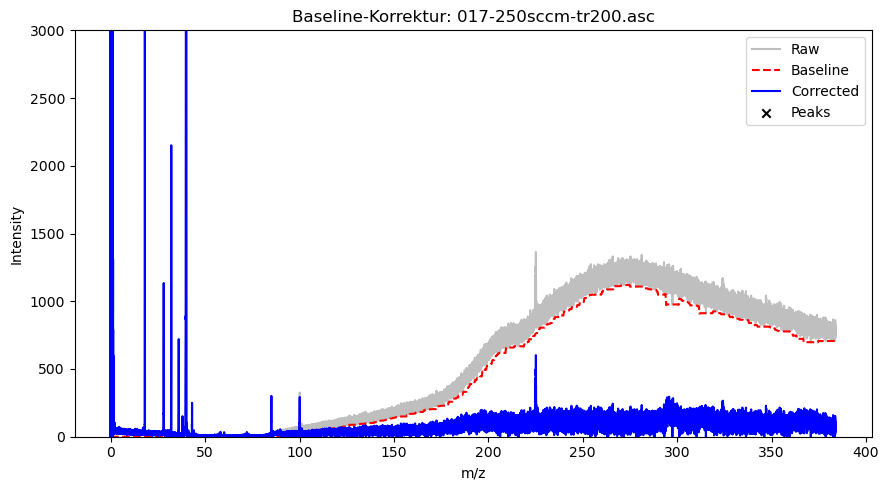


== Bearbeite Datei: 018-50sccm-tr200.asc ==
83394.42690728334
File: 018-50sccm-tr200.asc | mz_range: 0.10-383.78 | fit points: 64076 | peaks_masked_in_fit: 11271 | peaks_found_total: 85 | fallback_used


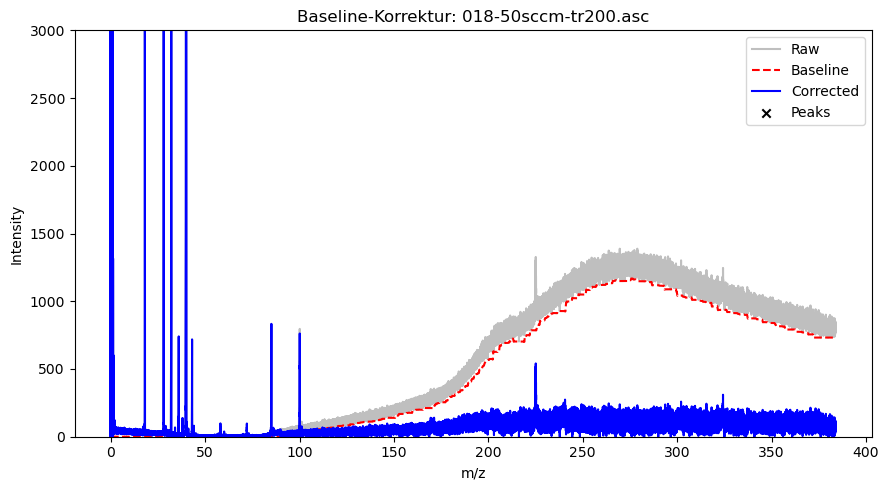

✅ Spektren mit Baseline-Korrektur gespeichert in 'alle_spektren_mit_baseline.csv'
✅ Integrierte Peaks gespeichert in 'alle_peaks_korrigiert.csv'


In [16]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline
from scipy.signal import find_peaks
from scipy.integrate import simpson
from scipy.ndimage import minimum_filter
from scipy.signal import savgol_filter

# ---------------------------
# Funktion: Metadaten aus Dateiname extrahieren
# ---------------------------
def extract_metadata(filename):
    """
    Extrahiert Datum, Wabe und Versuch aus Dateinamen wie:
    '2025-09-10_Wabe8_TR200.asc'
    """
    meta = {}
    base = os.path.basename(filename).replace(".asc", "")
    parts = base.split("_")
    if len(parts) >= 3:
        meta['Datum'] = parts[0]
        meta['Wabe'] = parts[1]
        meta['Versuch'] = parts[2]
    return meta

# ---------------------------
# Funktion: Datei einlesen, Baseline korrigieren & Peaks finden
# ---------------------------
def process_file(filepath,
                 lam=1e6,
                 p=0.001,
                 peak_distance=5,
                 peak_window=3,
                 baseline_start=90,
                 peak_mask_prominence_factor=0.02,
                 fallback_minfilter_fraction=0.02,
                 final_prominence_factor=0.01):
    """
    Lädt Datei, sortiert nach m/z, maskiert Peaks im Fit-Bereich (mit Prominenz),
    fitet Baseline ab baseline_start (ALS). Falls keine Peaks gefunden werden,
    probiert ein alternatives Baseline-Verfahren (minimum_filter + savgol).
    Rückgabe: mz, intensity, baseline, corrected, peaks_indices, peak_data
    """

    with open(filepath, encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    # Header suchen
    try:
        start_index = next(
            i for i, line in enumerate(lines) if line.strip().startswith("Mass / Counts")
        ) + 1
    except StopIteration:
        print(f"⚠️ Kein Header 'Mass / Counts' in Datei: {filepath}")
        return None, None, None, None, [], []

    data = [line.strip().split("\t") for line in lines[start_index:] if line.strip()]
    mz = np.array([float(row[0]) for row in data])
    intensity = np.array([float(row[1]) for row in data])

    if len(mz) == 0 or len(intensity) == 0:
        print(f"⚠️ Leere Daten in Datei: {filepath}")
        return None, None, None, None, [], []

    # sicherstellen, dass mz aufsteigend ist
    order = np.argsort(mz)
    mz = mz[order]
    intensity = intensity[order]

    # Startindex für Baseline-Fit
    start_idx = np.searchsorted(mz, baseline_start)
    if start_idx >= len(mz):
        print(f"⚠️ Kein m/z >= {baseline_start} in Datei: {os.path.basename(filepath)}")
        baseline = np.zeros_like(intensity)
        corrected = intensity - baseline
        peaks_final = np.array([], dtype=int)
        peak_data = []
        return mz, intensity, baseline, corrected, peaks_final, peak_data

    # Fit-Bereich
    intensity_fit = intensity[start_idx:]
    n_fit = len(intensity_fit)

    # --- 1) Peaks im Fit-Bereich maskieren ---
    prom_thresh = peak_mask_prominence_factor * max(np.max(intensity_fit), 1.0)
    peaks_in_fit, props = find_peaks(intensity_fit, prominence=prom_thresh, distance=max(1, int(peak_distance/2)))
    peak_mask = np.zeros_like(intensity_fit, dtype=bool)
    mask_width = max(1, int(peak_window))
    for pi in peaks_in_fit:
        lo = max(0, pi - mask_width)
        hi = min(n_fit, pi + mask_width + 1)
        peak_mask[lo:hi] = True

    x_fit = np.arange(n_fit)
    good = ~peak_mask
    intensity_fit_masked = intensity_fit.copy()
    if good.sum() >= 2:
        intensity_fit_masked[~good] = np.interp(x_fit[~good], x_fit[good], intensity_fit[good])

    # --- 2) ALS-Baseline ---
    baseline_fit = Baseline(intensity_fit_masked).asls(lam=lam, p=p)[0]
    baseline = np.zeros_like(intensity)
    baseline[start_idx:] = baseline_fit
    corrected = intensity - baseline

    # Peaks auf korrigierten Daten
    mask = mz >= 15
    mz_peaks = mz[mask]
    corrected_peaks = corrected[mask]
    noise_mask = mz < 15
    noise_level = np.std(corrected[noise_mask]) if np.any(noise_mask) else np.std(corrected)
    threshold = noise_level * 10
    peaks, _ = find_peaks(corrected_peaks, height=threshold, distance=peak_distance)

    # Integration pro Peak
    peak_data = []
    for peak in peaks:
        start = max(peak - peak_window, 0)
        end = min(peak + peak_window + 1, len(mz))
        area = simpson(corrected[start:end], mz[start:end])
        peak_data.append({'m/z': mz[peak], 'area': area})

    # Fallback
    fallback_used = False
    if len(peaks) == 0:
        fallback_used = True
        win = max(3, int(n_fit * fallback_minfilter_fraction))
        if win % 2 == 0:
            win += 1
        minf = minimum_filter(intensity_fit, size=win)
        sg_win = min(101, win if win % 2 == 1 else win+1)
        if sg_win < 3:
            sg_win = 3
        baseline_fit_alt = savgol_filter(minf, window_length=sg_win, polyorder=2)
        baseline_alt = np.zeros_like(intensity)
        baseline_alt[start_idx:] = baseline_fit_alt
        corrected_alt = intensity - baseline_alt

        max_corr_alt = np.max(corrected_alt)
        std_corr_alt = np.std(corrected_alt)
        prom_alt = max(0.005 * max_corr_alt, std_corr_alt)
        height_alt = max(1e-6 * max_corr_alt, np.mean(corrected_alt) + 1.0 * std_corr_alt)
        peaks_alt, props_alt = find_peaks(corrected_alt, height=height_alt, prominence=prom_alt, distance=max(1, int(peak_distance/2)))
        print(height_alt)
        if len(peaks_alt) > 0:
            baseline = baseline_alt
            corrected = corrected_alt
            peaks_final = peaks_alt
            peak_data = []
            for peak in peaks_final:
                start = max(peak - peak_window, 0)
                end = min(peak + peak_window + 1, len(mz))
                area = simpson(corrected[start:end], mz[start:end])
                peak_data.append({'m/z': mz[peak], 'area': area})
        else:
            peaks_final = peaks
    else:
        peaks_final = peaks

    # Debug
    print(f"File: {os.path.basename(filepath)} | mz_range: {mz.min():.2f}-{mz.max():.2f} | "
          f"fit points: {n_fit} | peaks_masked_in_fit: {len(peaks_in_fit)} | peaks_found_total: {len(peaks_final)}"
          + (f" | fallback_used" if fallback_used else ""))

    return mz, intensity, baseline, corrected, peaks_final, peak_data

# ---------------------------
# Hauptprogramm
# ---------------------------
folder = r"C:\Users\adako\Desktop\Wabenreaktor_Alacac3\Messdaten_Ilyas\8mm Wabe_Reproduzierung\2025-09-10\TR200"
files = [f for f in os.listdir(folder) if f.endswith(".asc")]
print(f"{len(files)} .asc-Dateien gefunden.")

all_peaks = []
all_spectra = []

for file in files:
    filepath = os.path.join(folder, file)
    print(f"\n== Bearbeite Datei: {file} ==")

    mz, intensity, baseline, corrected, peaks, peak_data = process_file(filepath)
    if mz is None:
        continue

    meta = extract_metadata(file)

    # Spektrum speichern
    df_spec = pd.DataFrame({
        'm/z': mz,
        'intensity_raw': intensity,
        'baseline': baseline,
        'intensity_corrected': corrected
    })
    for key, value in meta.items():
        df_spec[key] = value
    df_spec['Datei'] = file
    all_spectra.append(df_spec)

    # Peaks speichern
    for peak in peak_data:
        peak.update(meta)
        peak['Datei'] = file
        all_peaks.append(peak)

    # Plot zur Kontrolle
    plt.figure(figsize=(9, 5))
    plt.plot(mz, intensity, color='gray', alpha=0.5, label="Raw")
    plt.plot(mz, baseline, 'r--', label="Baseline")
    plt.plot(mz, corrected, 'b', label="Corrected")
    if len(peaks) > 0:
        plt.scatter(mz[peaks], corrected[peaks], color='k', marker='x', label="Peaks")
    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.title(f"Baseline-Korrektur: {file}")
    plt.legend()
    plt.ylim(0, 3000)
    plt.tight_layout()
    plt.show()

# Ergebnisse speichern
if len(all_spectra) > 0:
    df_all_spec = pd.DataFrame(pd.concat(all_spectra, ignore_index=True))
    df_all_spec.to_csv("alle_spektren_mit_baseline.csv", index=False)
    print("✅ Spektren mit Baseline-Korrektur gespeichert in 'alle_spektren_mit_baseline.csv'")

if len(all_peaks) > 0:
    df_all_peaks = pd.DataFrame(all_peaks)
    df_all_peaks.to_csv("alle_peaks_korrigiert.csv", index=False)
    print("✅ Integrierte Peaks gespeichert in 'alle_peaks_korrigiert.csv'")


14 .asc-Dateien gefunden.

== Bearbeite Datei: 003-650sccm-tr200.asc ==
10
File: 003-650sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 13089 | peaks_found_total: 56 | fallback_used


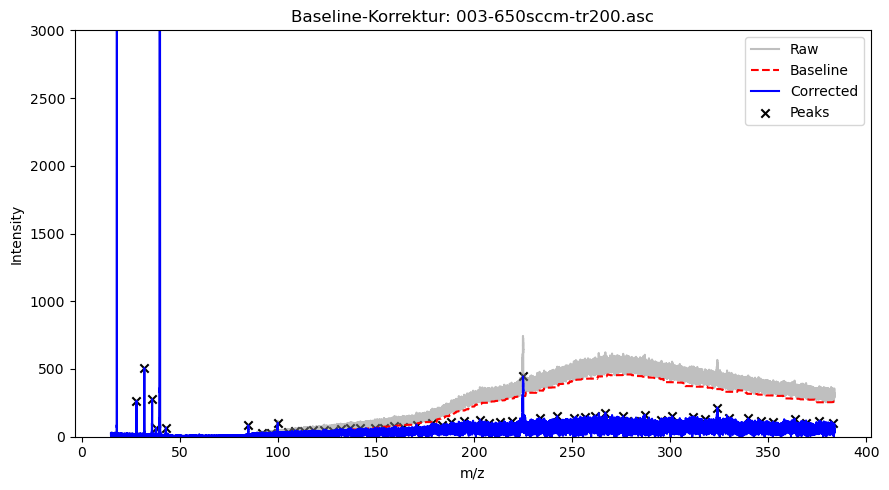


== Bearbeite Datei: 004-600sccm-tr200.asc ==
10
File: 004-600sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 12093 | peaks_found_total: 56 | fallback_used


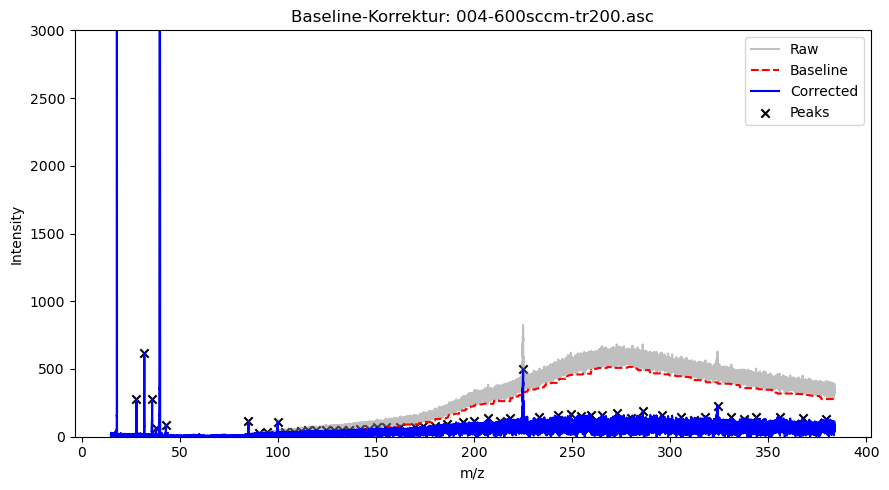


== Bearbeite Datei: 005-550sccm-tr200.asc ==
10
File: 005-550sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11889 | peaks_found_total: 55 | fallback_used


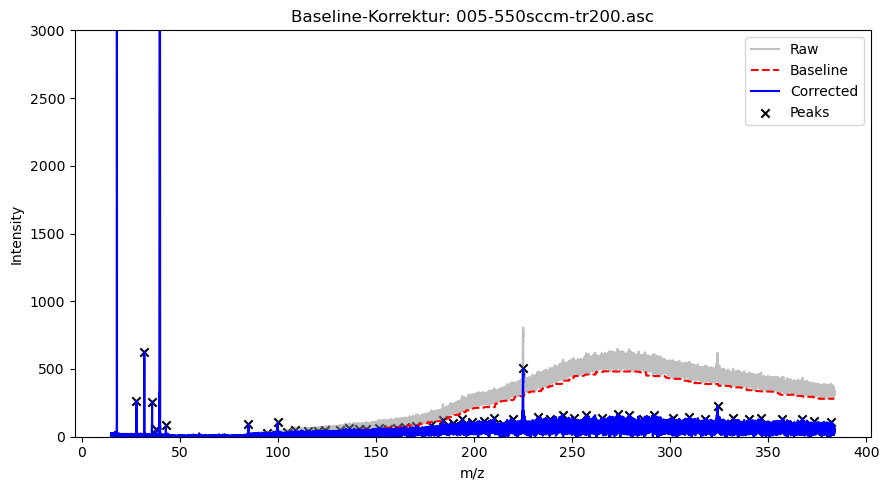


== Bearbeite Datei: 006-500sccm-tr200.asc ==
10
File: 006-500sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11642 | peaks_found_total: 51 | fallback_used


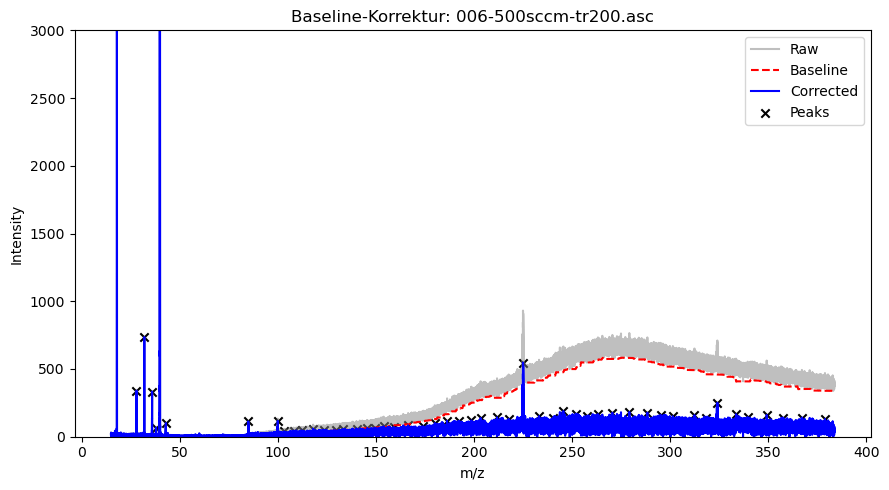


== Bearbeite Datei: 007-450sscm-tr200.asc ==
10
File: 007-450sscm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11030 | peaks_found_total: 55 | fallback_used


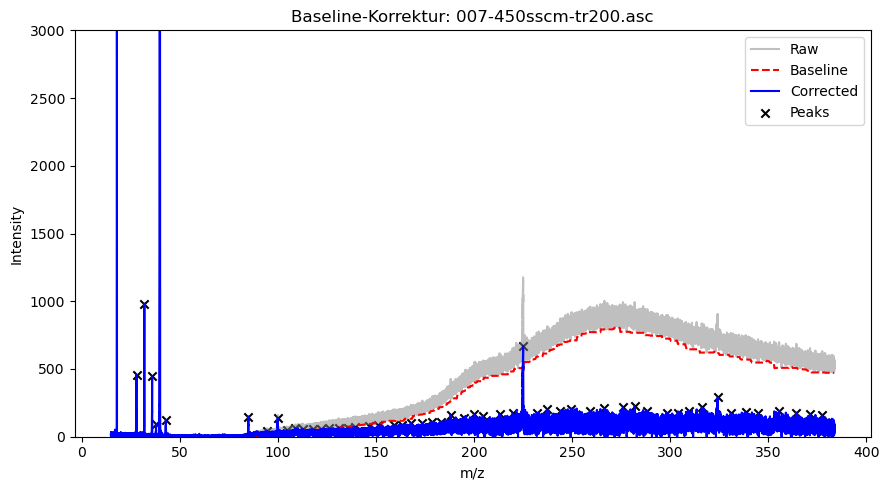


== Bearbeite Datei: 008-400sccm-tr200.asc ==
10
File: 008-400sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 10374 | peaks_found_total: 57 | fallback_used


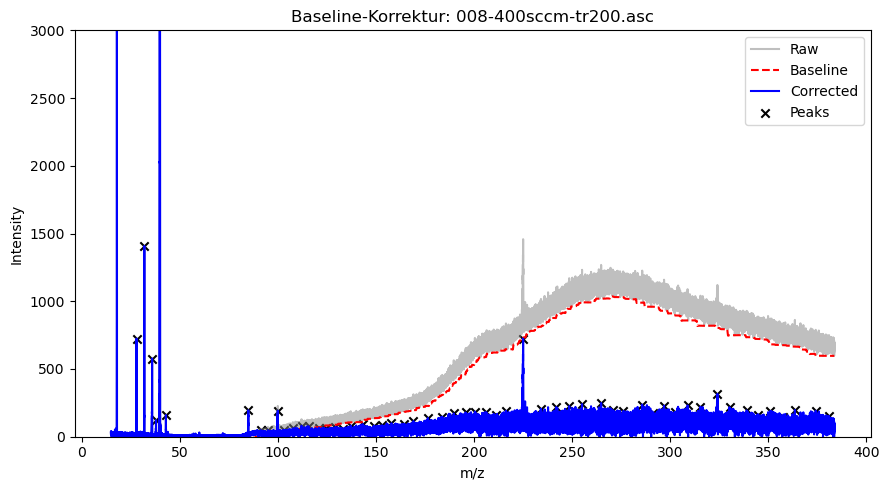


== Bearbeite Datei: 009-350sccm-tr200.asc ==
10
File: 009-350sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11004 | peaks_found_total: 54 | fallback_used


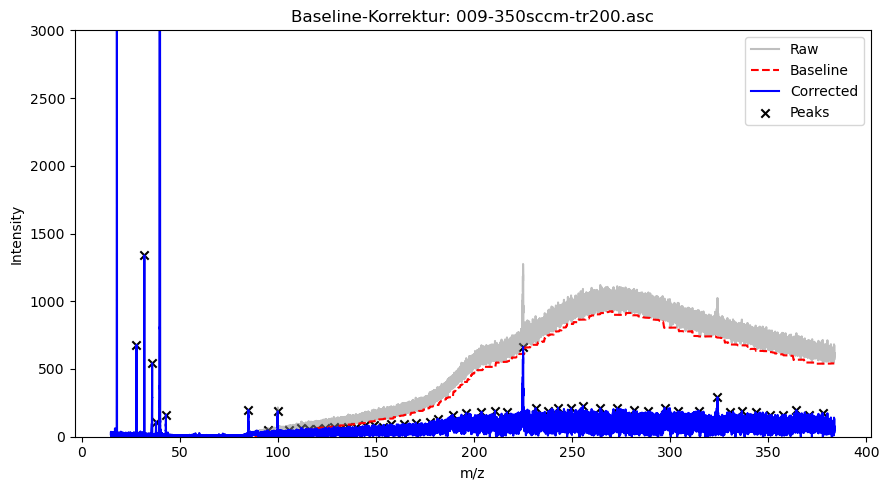


== Bearbeite Datei: 010-300sccm-tr200.asc ==
10
File: 010-300sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11212 | peaks_found_total: 53 | fallback_used


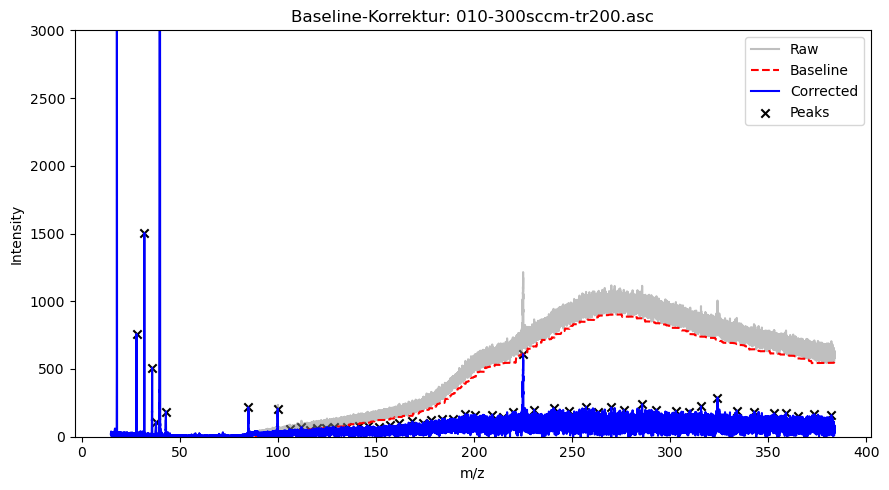


== Bearbeite Datei: 011-200sccm-tr200.asc ==
10
File: 011-200sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11385 | peaks_found_total: 55 | fallback_used


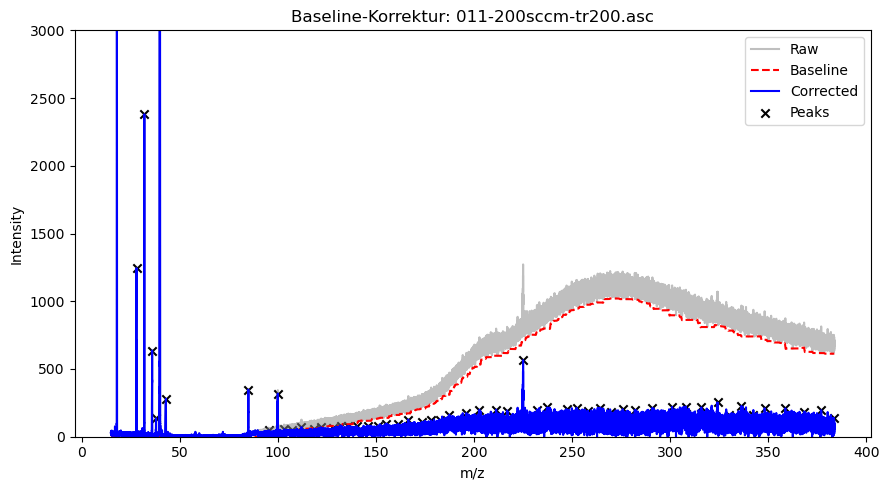


== Bearbeite Datei: 012-150sccm-tr200.asc ==
10
File: 012-150sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11322 | peaks_found_total: 56 | fallback_used


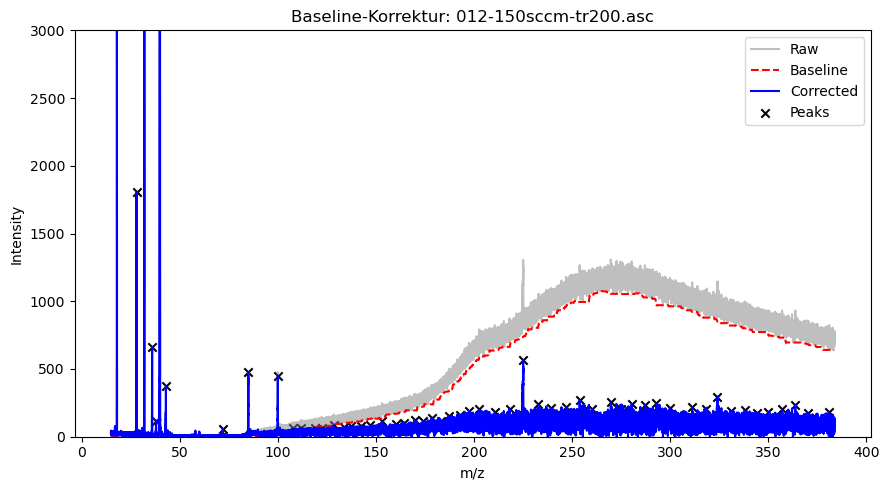


== Bearbeite Datei: 013-100sccm-tr200.asc ==
10
File: 013-100sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11198 | peaks_found_total: 53 | fallback_used


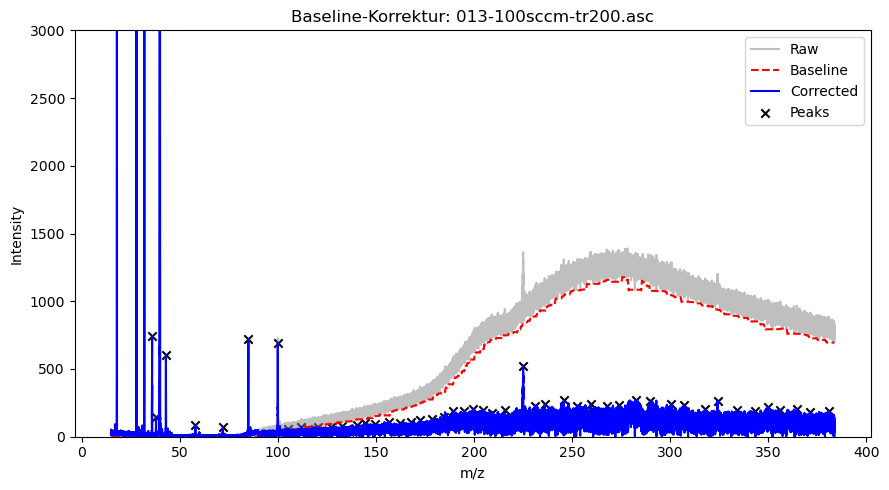


== Bearbeite Datei: 016-700sccm-tr200.asc ==
10
File: 016-700sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 10781 | peaks_found_total: 59 | fallback_used


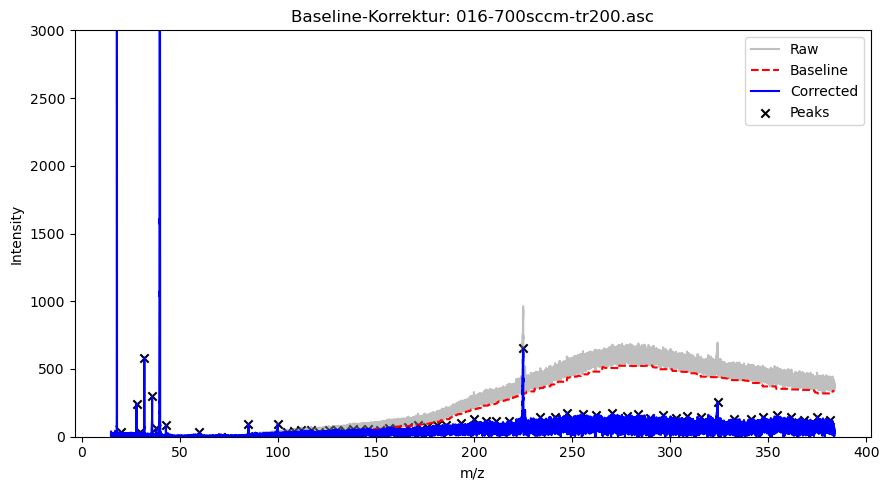


== Bearbeite Datei: 017-250sccm-tr200.asc ==
10
File: 017-250sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11047 | peaks_found_total: 54 | fallback_used


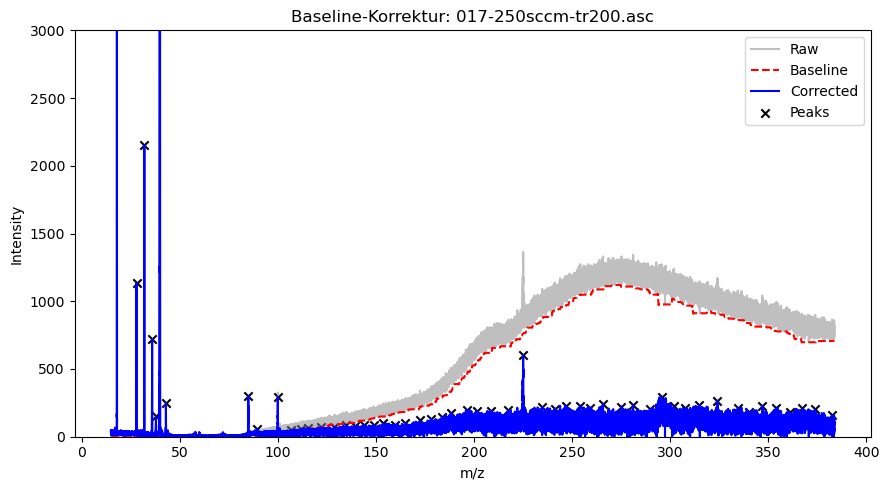


== Bearbeite Datei: 018-50sccm-tr200.asc ==
10
File: 018-50sccm-tr200.asc | mz_range: 15.00-383.78 | fit points: 64076 | peaks_masked_in_fit: 11271 | peaks_found_total: 60 | fallback_used


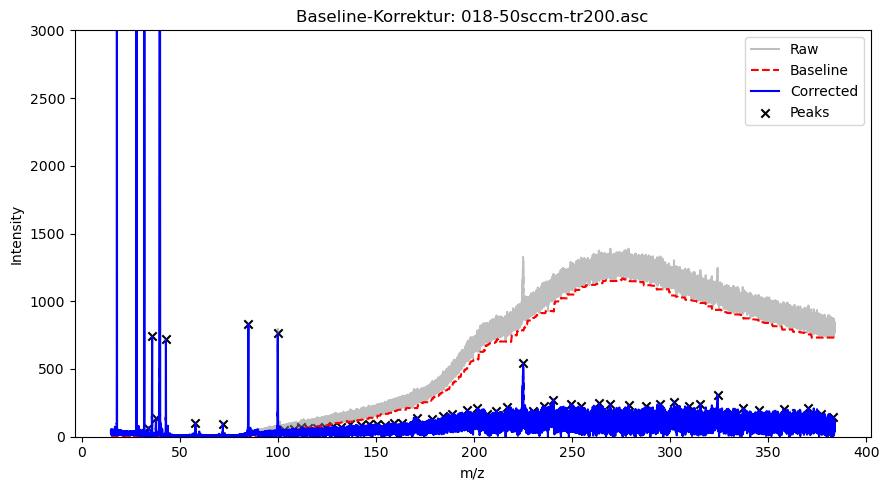

✅ Spektren mit Baseline-Korrektur gespeichert in 'alle_spektren_mit_baseline.csv'
✅ Integrierte Peaks gespeichert in 'alle_peaks_korrigiert.csv'


In [36]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline
from scipy.signal import find_peaks
from scipy.integrate import simpson
from scipy.ndimage import minimum_filter
from scipy.signal import savgol_filter

# ---------------------------
# Funktion: Metadaten aus Dateiname extrahieren
# ---------------------------
def extract_metadata(filename):
    """
    Extrahiert Datum, Wabe und Versuch aus Dateinamen wie:
    '2025-09-10_Wabe8_TR200.asc'
    """
    meta = {}
    base = os.path.basename(filename).replace(".asc", "")
    parts = base.split("_")
    if len(parts) >= 3:
        meta['Datum'] = parts[0]
        meta['Wabe'] = parts[1]
        meta['Versuch'] = parts[2]
    return meta

# ---------------------------
# Funktion: Datei einlesen, Baseline korrigieren & Peaks finden
# ---------------------------
def process_file(filepath,
                 lam=1e6,
                 p=0.001,
                 peak_distance=5,
                 peak_window=3,
                 baseline_start=90,
                 peak_mask_prominence_factor=0.02,
                 fallback_minfilter_fraction=0.02,
                 final_prominence_factor=0.01):
    """
    Lädt Datei, sortiert nach m/z, maskiert Peaks im Fit-Bereich (mit Prominenz),
    fitet Baseline ab baseline_start (ALS). Falls keine Peaks gefunden werden,
    probiert ein alternatives Baseline-Verfahren (minimum_filter + savgol).
    Rückgabe: mz, intensity, baseline, corrected, peaks_indices, peak_data
    """

    with open(filepath, encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    # Header suchen
    try:
        start_index = next(
            i for i, line in enumerate(lines) if line.strip().startswith("Mass / Counts")
        ) + 1
    except StopIteration:
        print(f"⚠️ Kein Header 'Mass / Counts' in Datei: {filepath}")
        return None, None, None, None, [], []

    data = [line.strip().split("\t") for line in lines[start_index:] if line.strip()]
    mz = np.array([float(row[0]) for row in data])
    intensity = np.array([float(row[1]) for row in data])

    # --- Nur Daten ab m/z 15 verwenden ---
    mask = mz >= 15
    mz = mz[mask]
    intensity = intensity[mask]

    if len(mz) == 0 or len(intensity) == 0:
        print(f"⚠️ Keine Daten >= 15 m/z in Datei: {filepath}")
        return None, None, None, None, [], []

    # sicherstellen, dass mz aufsteigend ist
    order = np.argsort(mz)
    mz = mz[order]
    intensity = intensity[order]

    # Startindex für Baseline-Fit
    start_idx = np.searchsorted(mz, baseline_start)
    if start_idx >= len(mz):
        print(f"⚠️ Kein m/z >= {baseline_start} in Datei: {os.path.basename(filepath)}")
        baseline = np.zeros_like(intensity)
        corrected = intensity - baseline
        peaks_final = np.array([], dtype=int)
        peak_data = []
        return mz, intensity, baseline, corrected, peaks_final, peak_data

    # Fit-Bereich
    intensity_fit = intensity[start_idx:]
    n_fit = len(intensity_fit)

    # --- 1) Peaks im Fit-Bereich maskieren ---
    prom_thresh = peak_mask_prominence_factor * max(np.max(intensity_fit), 1.0)
    peaks_in_fit, props = find_peaks(intensity_fit, prominence=prom_thresh, distance=max(1, int(peak_distance/2)))
    peak_mask = np.zeros_like(intensity_fit, dtype=bool)
    mask_width = max(1, int(peak_window))
    for pi in peaks_in_fit:
        lo = max(0, pi - mask_width)
        hi = min(n_fit, pi + mask_width + 1)
        peak_mask[lo:hi] = True

    x_fit = np.arange(n_fit)
    good = ~peak_mask
    intensity_fit_masked = intensity_fit.copy()
    if good.sum() >= 2:
        intensity_fit_masked[~good] = np.interp(x_fit[~good], x_fit[good], intensity_fit[good])

    # --- 2) ALS-Baseline ---
    baseline_fit = Baseline(intensity_fit_masked).asls(lam=lam, p=p)[0]
    baseline = np.zeros_like(intensity)
    baseline[start_idx:] = baseline_fit
    corrected = intensity - baseline

    # Peaks auf korrigierten Daten
    peaks, _ = find_peaks(corrected, height=np.std(corrected), distance=peak_distance)
   # print(np.std(corrected))

    # Integration pro Peak
    peak_data = []
    for peak in peaks:
        start = max(peak - peak_window, 0)
        end = min(peak + peak_window + 1, len(mz))
        area = simpson(corrected[start:end], mz[start:end])
        peak_data.append({'m/z': mz[peak], 'area': area})

    # Fallback
    fallback_used = False
    if len(peaks) == 0:
        fallback_used = True
        win = max(3, int(n_fit * fallback_minfilter_fraction))
        if win % 2 == 0:
            win += 1
        minf = minimum_filter(intensity_fit, size=win)
        sg_win = min(101, win if win % 2 == 1 else win+1)
        if sg_win < 3:
            sg_win = 3
        baseline_fit_alt = savgol_filter(minf, window_length=sg_win, polyorder=2)
        baseline_alt = np.zeros_like(intensity)
        baseline_alt[start_idx:] = baseline_fit_alt
        corrected_alt = intensity - baseline_alt

        max_corr_alt = np.max(corrected_alt)
        std_corr_alt = np.std(corrected_alt)
        prom_alt = max(0.0005 * max_corr_alt, std_corr_alt*0.005)
        #height_alt = max(1e-6 * max_corr_alt, np.mean(corrected_alt) + 0.000001 * std_corr_alt)
        height_alt = 10
        #peaks_alt, props_alt = find_peaks(corrected_alt, height=height_alt, prominence=prom_alt, distance=max(1, int(peak_distance/2)))
        peaks_alt, props_alt = find_peaks(corrected_alt, height=height_alt, prominence=prom_alt, distance=1000)
        print(height_alt)
        if len(peaks_alt) > 0:
            baseline = baseline_alt
            corrected = corrected_alt
            peaks_final = peaks_alt
            peak_data = []
            for peak in peaks_final:
                start = max(peak - peak_window, 0)
                end = min(peak + peak_window + 1, len(mz))
                area = simpson(corrected[start:end], mz[start:end])
                peak_data.append({'m/z': mz[peak], 'area': area})
        else:
            peaks_final = peaks
    else:
        peaks_final = peaks

    # Debug
    print(f"File: {os.path.basename(filepath)} | mz_range: {mz.min():.2f}-{mz.max():.2f} | "
          f"fit points: {n_fit} | peaks_masked_in_fit: {len(peaks_in_fit)} | peaks_found_total: {len(peaks_final)}"
          + (f" | fallback_used" if fallback_used else ""))

    return mz, intensity, baseline, corrected, peaks_final, peak_data

# ---------------------------
# Hauptprogramm
# ---------------------------
folder = r"C:\Users\adako\Desktop\Wabenreaktor_Alacac3\Messdaten_Ilyas\8mm Wabe_Reproduzierung\2025-09-10\TR200"
files = [f for f in os.listdir(folder) if f.endswith(".asc")]
print(f"{len(files)} .asc-Dateien gefunden.")

all_peaks = []
all_spectra = []

for file in files:
    filepath = os.path.join(folder, file)
    print(f"\n== Bearbeite Datei: {file} ==")

    mz, intensity, baseline, corrected, peaks, peak_data = process_file(filepath)
    if mz is None:
        continue

    meta = extract_metadata(file)

    # Spektrum speichern
    df_spec = pd.DataFrame({
        'm/z': mz,
        'intensity_raw': intensity,
        'baseline': baseline,
        'intensity_corrected': corrected
    })
    for key, value in meta.items():
        df_spec[key] = value
    df_spec['Datei'] = file
    all_spectra.append(df_spec)

    # Peaks speichern
    for peak in peak_data:
        peak.update(meta)
        peak['Datei'] = file
        all_peaks.append(peak)

    # Plot zur Kontrolle
    plt.figure(figsize=(9, 5))
    plt.plot(mz, intensity, color='gray', alpha=0.5, label="Raw")
    plt.plot(mz, baseline, 'r--', label="Baseline")
    plt.plot(mz, corrected, 'b', label="Corrected")
    if len(peaks) > 0:
        plt.scatter(mz[peaks], corrected[peaks], color='k', marker='x', label="Peaks")
    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.title(f"Baseline-Korrektur: {file}")
    plt.legend()
    plt.ylim(0, 3000)
    plt.tight_layout()
    plt.show()

# Ergebnisse speichern
if len(all_spectra) > 0:
    df_all_spec = pd.DataFrame(pd.concat(all_spectra, ignore_index=True))
    df_all_spec.to_csv("alle_spektren_mit_baseline.csv", index=False)
    print("✅ Spektren mit Baseline-Korrektur gespeichert in 'alle_spektren_mit_baseline.csv'")

if len(all_peaks) > 0:
    df_all_peaks = pd.DataFrame(all_peaks)
    df_all_peaks.to_csv("alle_peaks_korrigiert.csv", index=False)
    print("✅ Integrierte Peaks gespeichert in 'alle_peaks_korrigiert.csv'")
